# 跑水文模型

## 数据准备

In [166]:
gauge_name = 2350900
 

In [167]:
from heffpy.utils import read_camel as rc

In [168]:
import datetime as dt
import pandas as pd
import os

In [169]:
met_dir = r"E:\CAMELS\Data\force\basin_mean_forcing\daymet"

# %%
start,end = dt.datetime(1985,1,1), \
    dt.datetime(2015,12,31)

met_file_path = os.path.join(met_dir,"%08d_lump_cida_forcing_leap.txt" % gauge_name)

# %%
met,lat,elev,area = rc.read_force(met_file_path,start,end)

C:\Users\zjssy\Anaconda3\lib\site-packages\heffpy\utils\read_camel.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfForce["TM"] = date


In [170]:
met.head()

,dayl,prcp,srad,swe,tmax,tmin,vp,TM
1827,35829.19,0.00,248.62,0.0,24.91,11.91,1393.06,1985-01-01
1828,35899.58,1.15,194.05,0.0,23.33,13.62,1560.40,1985-01-02
1829,35940.49,35.04,129.44,0.0,16.72,8.92,1153.85,1985-01-03
1830,35942.39,16.18,197.40,0.0,12.64,0.14,615.01,1985-01-04
1831,35942.39,0.00,207.17,0.0,6.52,-2.45,511.80,1985-01-05


In [171]:
# %%
year = met["TM"].apply(lambda x: dt.datetime(x.year,1,1))
doy = met["TM"] - year
doy = doy.apply(lambda x:x.days).values.astype("int32")

In [172]:
Q_dir = r"E:\CAMELS\Data\streamflow"
q_file_path = os.path.join(Q_dir,"%08d_streamflow_qc.txt" % gauge_name)

In [173]:
q = rc.read_usgs(q_file_path, start,end)

In [174]:
q.head()

,TM,Q
0,1985-03-07,14.186740
1,1985-03-08,13.563770
2,1985-03-09,12.969116
3,1985-03-10,12.629314
4,1985-03-11,12.261195


## 集总式模型

In [175]:
from heffpy.hydro import SACSMA,hargreaves,XAJ,HBV

In [176]:
from heffpy.calibration.loss import NSCE
from heffpy.calibration.optimization import SCEUA

In [177]:
from numpy import ndarray

### 计算蒸发

In [178]:
year = met["TM"].apply(lambda x: dt.datetime(x.year,1,1))
doy = met["TM"] - year
doy = doy.apply(lambda x:x.days).values.astype("int32")


prcp = met.prcp.values
tmax = met.tmax.values
tmin = met.tmin.values

tavg = (tmax + tmin) / 2

# %%
pet = hargreaves(tmin,tmax, tavg, doy,46.2)

## 模型率定和模拟

In [179]:
sac = SACSMA(
    prcp[0:1000],pet[0:1000],
    dt = 24,area = area
)

xaj = XAJ(
    prcp[0:1000],pet[0:1000],
    dt = 24,area = area
)

hbv = HBV(
    prcp[0:1000],pet[0:1000],tavg[0:1000],
    dt = 24,area = area
)

sac2 = SACSMA(
    prcp,pet,
    dt = 24,area = area
)

xaj2 = XAJ(
    prcp,pet,
    dt = 24,area = area
)

hbv2 = HBV(
    prcp,pet,tavg,
    dt = 24,area = area
)

In [180]:
hbv.get_parameters()

,bu,bl,value
BETA,6.000,1.000,3.5000
CET,5.000,0.010,2.5050
FC,600.000,30.000,315.0000
K0,1.000,0.400,0.7000
K1,0.200,0.035,0.1175
K2,0.035,0.020,0.0275
LP,6.000,0.010,3.0050
PERC,3.000,0.010,1.5050
UZL,70.000,15.000,42.5000
PCORR,1.990,0.010,1.0000


In [181]:
cali_models = {"xaj":xaj,"sac":sac,"hbv":hbv}
simu_models = {"xaj":xaj2,"sac":sac2,"hbv":hbv2}
cons_loc = [[6],[13,14,15], [9,12]]

### 参数优化

In [182]:
loss = NSCE(q.Q.values[0:1000], len_warmup= 300)

In [184]:
for i in range(3):
    model_name = list(cali_models.keys())[i]
    sce = SCEUA(
        cali_models[model_name], loss,Verbose=False,maxn=100000
    )
    sce.set_constant_positions(cons_loc[i])
    bextx,bestf = sce.run()

    print(bestf)
    simuQ = simu_models[model_name].excute(bextx)
    
    q[model_name] = simuQ[0:len(q)]

save_dir = os.path.join(
    r"data",str(gauge_name)
)

if(not os.path.exists(save_dir)):
    os.mkdir(save_dir)

q.to_csv(os.path.join(save_dir, "Q.csv"))
met.to_csv(os.path.join(save_dir, "Meteo.csv"))

0.7466309891746108
-0.27812354937699313
-0.08763228882447283


In [123]:
sce.get_best_solution()

,parnames,parvalues
0,uztwm,75.500
1,uzfwm,75.500
2,lztwm,250.500
3,lzfpm,500.500
4,lzfsm,500.500
5,uzk,0.200
6,lzpk,0.425
7,lzsk,0.013
8,zperc,0.130
9,rexp,125.500


In [124]:
sce.set_constant_positions([13,14,15])

In [125]:
bextx,bestf = sce.run()

In [126]:
bestf

-0.816528545968005

In [127]:
sac = SACSMA(
    prcp[0:],pet[0:],
    dt = 24,area = area
)

simuQ = sac.excute(bextx)

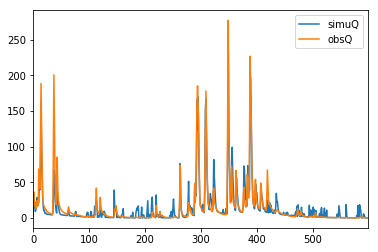

In [128]:
pd.DataFrame({"simuQ":simuQ[400:1000], "obsQ":q.Q.values[400:1000]}).plot()